<a href="https://colab.research.google.com/github/nandivardhan522/Drug-Target-Interaction/blob/main/Drug_Discovery_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install PyTDC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.3/151.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip show PyTDC

Name: pytdc
Version: 1.1.14
Summary: Therapeutics Commons
Home-page: https://github.com/mims-harvard/TDC
Author: PyTDC Team
Author-email: amva13@alum.mit.edu
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: accelerate, cellxgene-census, dataclasses, datasets, evaluate, fuzzywuzzy, gget, huggingface-hub, numpy, openpyxl, pandas, pydantic, rdkit, requests, scikit-learn, seaborn, tiledbsoma, tqdm, transformers, yapf
Required-by: 


#Import required libraries

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tdc.multi_pred import DTI
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from transformers import BertTokenizer

#Load Datasets

#Convert to Pandas Dataframes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

##Binding DB Dataset

In [ ]:
from tdc.multi_pred import DTI
BindingDB_Kd = DTI(name = 'BindingDB_Kd')
BindingDB_IC50 = DTI(name = 'BindingDB_IC50')
BindingDB_Ki = DTI(name = 'BindingDB_Ki')

Downloading...
100%|██████████| 54.4M/54.4M [00:02<00:00, 22.7MiB/s]
Loading...
Done!
Downloading...
100%|██████████| 839M/839M [00:41<00:00, 20.2MiB/s]
Loading...
Done!
Downloading...
100%|██████████| 236M/236M [00:11<00:00, 20.6MiB/s]
Loading...
Done!


In [ ]:
df_BindingDB_Kd = pd.DataFrame(BindingDB_Kd.get_data())
df_BindingDB_IC50=pd.DataFrame(BindingDB_IC50.get_data())
df_BindingDB_Ki = pd.DataFrame(BindingDB_Ki.get_data())
print(df_BindingDB_Kd.shape)
print(df_BindingDB_IC50.shape)
print(df_BindingDB_Ki.shape)

(52274, 5)
(990630, 5)
(374820, 5)


In [ ]:
print(df_BindingDB_Kd['Drug_ID'].nunique())
print(df_BindingDB_IC50['Drug_ID'].nunique())
print(df_BindingDB_Ki['Drug_ID'].nunique())

10636
538540
171831


In [ ]:
print(df_BindingDB_Kd['Drug'].nunique())
print(df_BindingDB_IC50['Drug'].nunique())
print(df_BindingDB_Ki['Drug'].nunique())

10661
548633
174547


In [ ]:
# Rename Y column to distinguish different units
df1 = df_BindingDB_Kd.rename(columns={"Y": "Y_Kd"})
df2 = df_BindingDB_IC50.rename(columns={"Y": "Y_IC50"})
df3 = df_BindingDB_Ki.rename(columns={"Y": "Y_Ki"})
print(df1.columns)
print(df2.columns)
print(df3.columns)


Index(['Drug_ID', 'Drug', 'Target_ID', 'Target', 'Y_Kd'], dtype='object')
Index(['Drug_ID', 'Drug', 'Target_ID', 'Target', 'Y_IC50'], dtype='object')
Index(['Drug_ID', 'Drug', 'Target_ID', 'Target', 'Y_Ki'], dtype='object')


In [ ]:
# Merge datasets on common columns
merged_df = df1.merge(df2, on=["Drug_ID", "Drug", "Target_ID", "Target"], how="outer").merge(df3, on=["Drug_ID", "Drug", "Target_ID", "Target"], how="outer")

In [ ]:
# Count unique values
num_drug_ids = merged_df["Drug_ID"].nunique()
num_drugs = merged_df["Drug"].nunique()

print(f"Unique Drug_IDs: {num_drug_ids}")
print(f"Unique Drug Names: {num_drugs}")

Unique Drug_IDs: 686705
Unique Drug Names: 699875


In [ ]:
# Drop Drug_ID and Target_ID columns
df_cleaned = merged_df.drop(columns=["Drug_ID", "Target_ID"])

# Create a new key by combining Drug and Target names
df_cleaned["Key"] = df_cleaned["Drug"] + "_" + df_cleaned["Target"]

# Reorder columns to have 'Key' as the first column
cols = ["Key"] + [col for col in df_cleaned.columns if col != "Key"]
df_cleaned = df_cleaned[cols]

df_cleaned.head()

,Key,Drug,Target,Y_Kd,Y_IC50,Y_Ki
0,CCn1cnc2c(N)ncnc21_MPNNSTALSLANVTYITMEIFIGLCAI...,CCn1cnc2c(N)ncnc21,MPNNSTALSLANVTYITMEIFIGLCAIVGNVLVICVVKLNPSLQTT...,NaN,NaN,100000.0
1,CCn1cnc2c(N)ncnc21_MPPYISAFQAAYIGIEVLIALVSVPGN...,CCn1cnc2c(N)ncnc21,MPPYISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,NaN,NaN,46000.0
2,CCn1cnc2c(N)ncnc21_MPIMGSSVYITVELAIAVLAILGNVLV...,CCn1cnc2c(N)ncnc21,MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVV...,NaN,NaN,2200.0
3,CCn1cnc2c(N)ncnc21_MLLETQDALYVALELVIAALSVAGNVL...,CCn1cnc2c(N)ncnc21,MLLETQDALYVALELVIAALSVAGNVLVCAAVGTANTLQTPTNYFL...,NaN,NaN,30000.0
4,CCn1cnc2c(N)ncnc21_MPPSISAFQAAYIGIEVLIALVSVPGN...,CCn1cnc2c(N)ncnc21,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,NaN,NaN,7400.0


In [ ]:
df_cleaned.shape

(1456250, 6)

In [ ]:
df_cleaned["Key"].nunique()

1236122

In [ ]:
df_cleaned = df_cleaned.groupby("Key", as_index=False).agg({
    "Drug": "first",  # Keep the first occurrence of Drug for each Key
    "Target": "first",  # Keep the first occurrence of Target for each Key
    "Y_Kd": "mean",  # Compute the mean for Y_Kd
    "Y_IC50": "mean",  # Compute the mean for Y_IC50
    "Y_Ki": "mean"  # Compute the mean for Y_Ki
})


In [ ]:
df_cleaned.shape

(1236122, 6)

In [ ]:
print(df_cleaned.head())

                                                 Key  \
0  B[P@@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C...   
1  B[P@@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C...   
2  B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)nc(SC)nc32...   
3  B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@...   
4  B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@...   

                                                Drug  \
0  B[P@@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C...   
1  B[P@@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C...   
2  B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)nc(SC)nc32...   
3  B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@...   
4  B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@...   

                                              Target  Y_Kd  Y_IC50     Y_Ki  
0  MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...   NaN     NaN  18000.0  
1  MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...   NaN     NaN    500.0  
2  MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...   NaN     NaN  56000.0  
3  MERDGCAGGGS

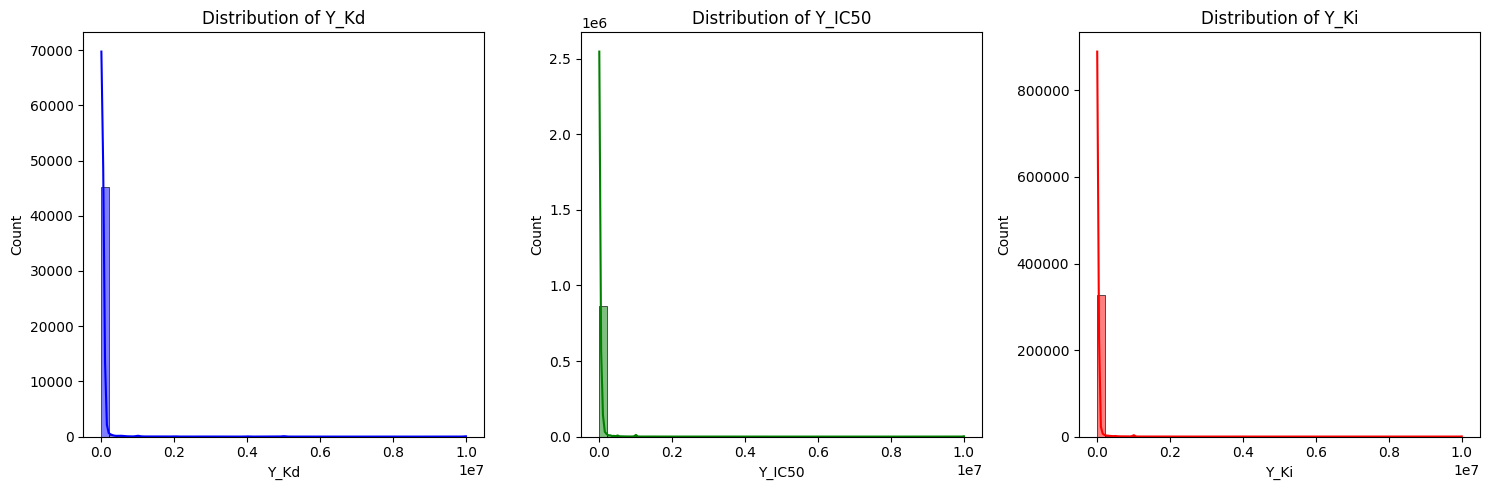

                                                 Key  \
0  B[P@@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C...   
1  B[P@@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C...   
2  B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)nc(SC)nc32...   
3  B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@...   
4  B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@...   

                                                Drug  \
0  B[P@@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C...   
1  B[P@@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C...   
2  B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)nc(SC)nc32...   
3  B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@...   
4  B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@...   

                                              Target  Y_Kd  Y_IC50     Y_Ki  
0  MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...   NaN     NaN  18000.0  
1  MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...   NaN     NaN    500.0  
2  MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...   NaN     NaN  56000.0  
3  MERDGCAGGGS

In [ ]:
# Visualization of transformed data with KDE (curved line)
plt.figure(figsize=(15, 5))

# Plot Y_Kd with KDE
plt.subplot(1, 3, 1)
sns.histplot(df_cleaned['Y_Kd'].dropna(), kde=True, color='blue', bins=50)
plt.title('Distribution of Y_Kd')

# Plot Y_IC50 with KDE
plt.subplot(1, 3, 2)
sns.histplot(df_cleaned['Y_IC50'].dropna(), kde=True, color='green', bins=50)
plt.title('Distribution of Y_IC50')

# Plot Y_Ki with KDE
plt.subplot(1, 3, 3)
sns.histplot(df_cleaned['Y_Ki'].dropna(), kde=True, color='red', bins=50)
plt.title('Distribution of Y_Ki')

# Display the plots
plt.tight_layout()
plt.show()

print(df_cleaned.head())

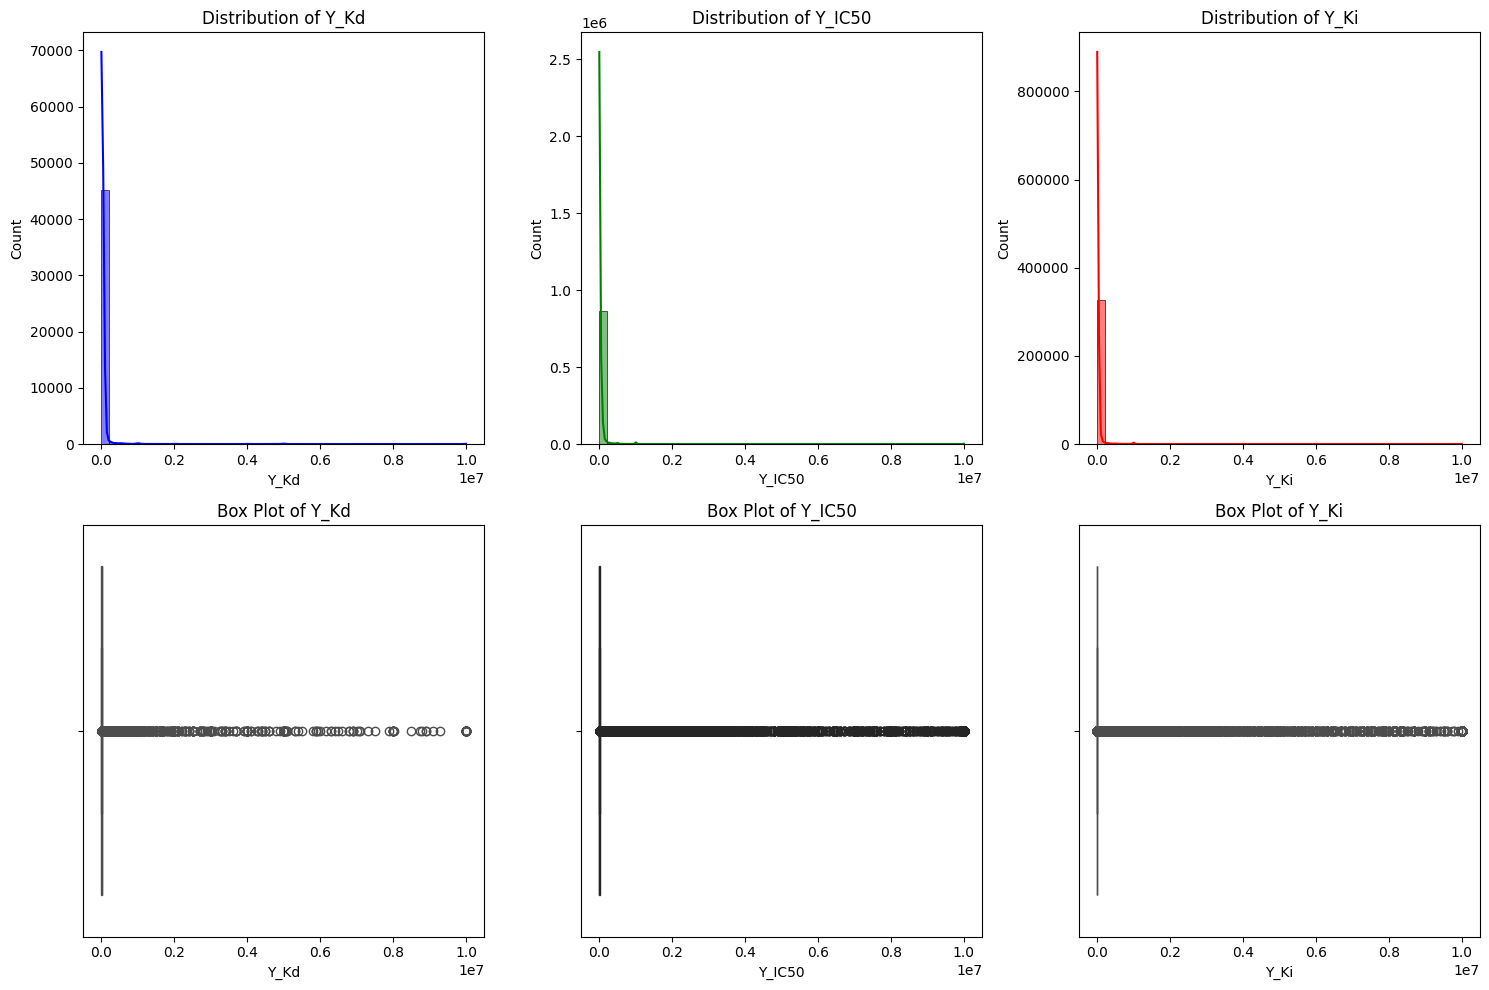

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Define the columns to visualize
columns = ['Y_Kd', 'Y_IC50', 'Y_Ki']
colors = ['blue', 'green', 'red']

# Loop through the columns to create histograms and box plots
for i, col in enumerate(columns):
    # Histogram with KDE
    sns.histplot(df_cleaned[col].dropna(), kde=True, color=colors[i], bins=50, ax=axes[0, i])
    axes[0, i].set_title(f'Distribution of {col}')

    # Box Plot
    sns.boxplot(x=df_cleaned[col], color=colors[i], ax=axes[1, i])
    axes[1, i].set_title(f'Box Plot of {col}')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to detect and remove outliers using IQR (only for non-NaN values)
def remove_outliers(temp_df1, column, threshold=1.5):
  # Select only non-NaN values for outlier detection
  non_nan_values = temp_df1[column].dropna()
  # Compute IQR
  Q1 = non_nan_values.quantile(0.25)
  Q3 = non_nan_values.quantile(0.75)
  IQR = Q3 - Q1

  # Compute bounds
  lower_bound = Q1 - threshold * IQR
  upper_bound = Q3 + threshold * IQR

  # Remove outliers only from non-NaN values
  return temp_df1[(temp_df1[column].isna()) | ((temp_df1[column] >= lower_bound) & (temp_df1[column] <= upper_bound))]



In [ ]:
def analyze_transform_remove_outliers_visualize(temp_df):

    # Log transformation
    temp_df['Y_Kd'] = -np.log10(temp_df['Y_Kd'])
    temp_df['Y_IC50'] = -np.log10(temp_df['Y_IC50'])
    temp_df['Y_Ki'] = -np.log10(temp_df['Y_Ki'])

    # Remove outliers while keeping NaN values
    df_no_outliers = remove_outliers(temp_df, 'Y_Kd')
    df_no_outliers = remove_outliers(df_no_outliers, 'Y_IC50')
    df_no_outliers = remove_outliers(df_no_outliers, 'Y_Ki')

    # Reset index
    df_no_outliers.reset_index(drop=True, inplace=True)
    # Print the new shape


    return df_no_outliers




# Call the function
df_transformed_no_outliers = analyze_transform_remove_outliers_visualize(df_cleaned.copy())
print("Shape before removing outliers:", df_cleaned.shape)
print("Shape after removing outliers:", df_transformed_no_outliers.shape)



Shape before removing outliers: (1236122, 6)
Shape after removing outliers: (1232518, 6)


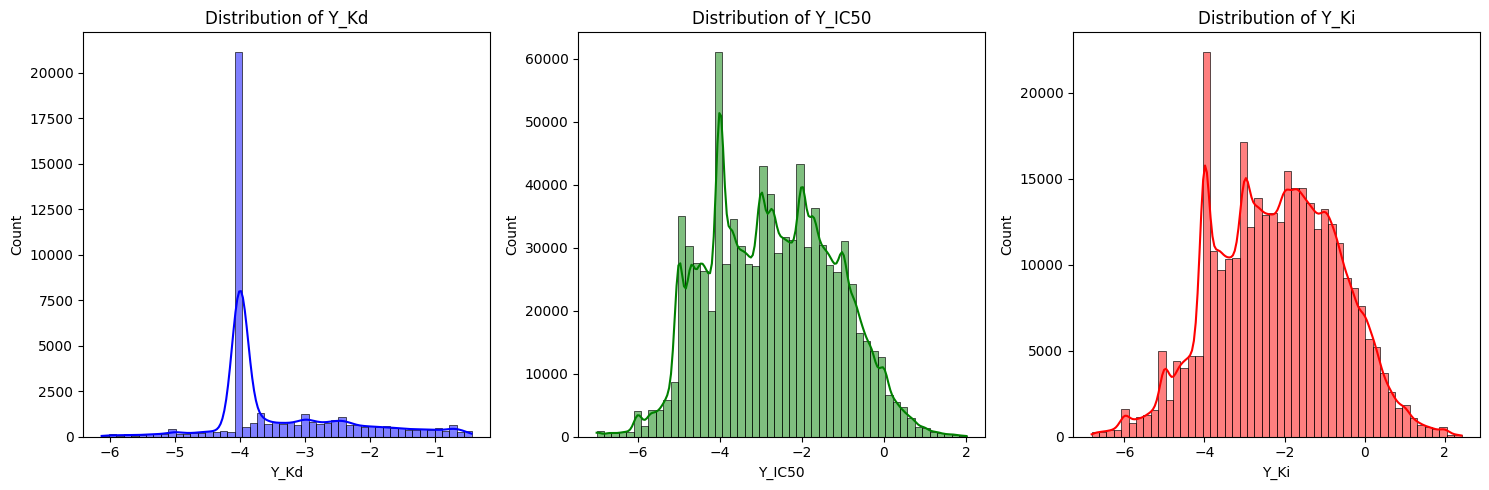

In [ ]:
#Visualization of transformed data with KDE (curved line)
plt.figure(figsize=(15, 5))

# Plot Y_Kd with KDE
plt.subplot(1, 3, 1)
sns.histplot(df_transformed_no_outliers['Y_Kd'].dropna(), kde=True, color='blue', bins=50)
plt.title('Distribution of Y_Kd')

# Plot Y_IC50 with KDE
plt.subplot(1, 3, 2)
sns.histplot(df_transformed_no_outliers['Y_IC50'].dropna(), kde=True, color='green', bins=50)
plt.title('Distribution of Y_IC50')

# Plot Y_Ki with KDE
plt.subplot(1, 3, 3)
sns.histplot(df_transformed_no_outliers['Y_Ki'].dropna(), kde=True, color='red', bins=50)
plt.title('Distribution of Y_Ki')

# Display the plots
plt.tight_layout()
plt.show()


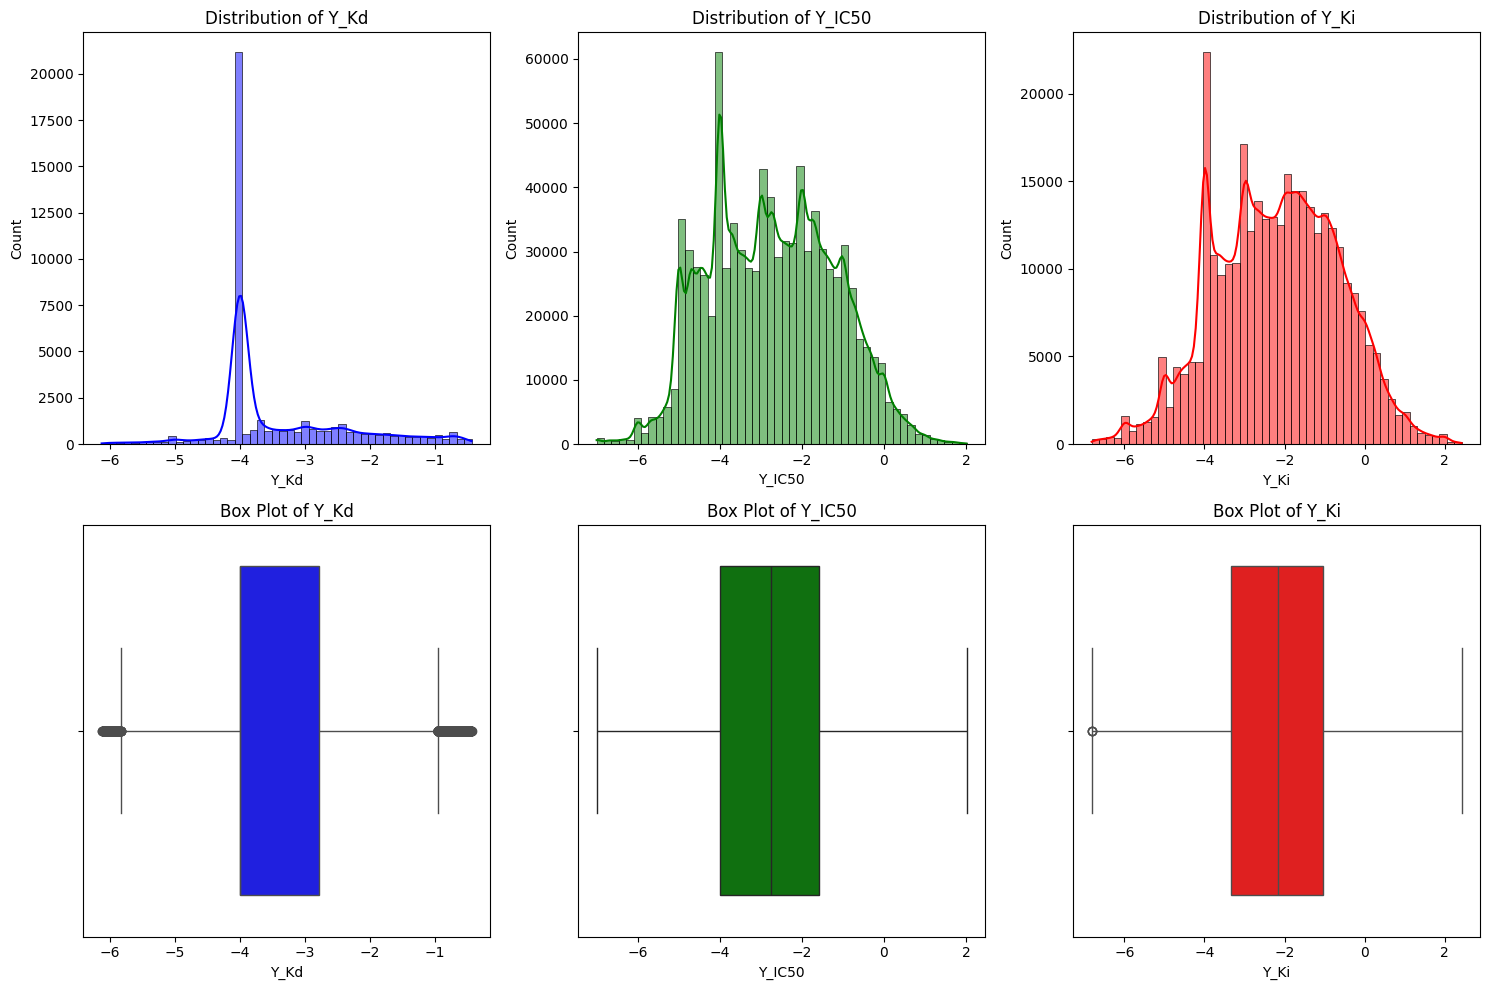

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Define the columns and colors
columns = ['Y_Kd', 'Y_IC50', 'Y_Ki']
colors = ['blue', 'green', 'red']

# Loop through the columns to create histograms and box plots
for i, col in enumerate(columns):
    # Histogram with KDE
    sns.histplot(df_transformed_no_outliers[col].dropna(), kde=True, color=colors[i], bins=50, ax=axes[0, i])
    axes[0, i].set_title(f'Distribution of {col}')

    # Box Plot
    sns.boxplot(x=df_transformed_no_outliers[col], color=colors[i], ax=axes[1, i])
    axes[1, i].set_title(f'Box Plot of {col}')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
df_transformed_no_outliers.shape

(1232518, 6)

In [ ]:
df_transformed_no_outliers.describe()

,Y_Kd,Y_IC50,Y_Ki
count,43892.000000,883595.000000,333813.000000
mean,-3.386073,-2.722369,-2.200429
std,1.054994,1.506175,1.542107
min,-6.130334,-7.000000,-6.818885
25%,-4.000000,-4.000000,-3.350054
50%,-4.000000,-2.740363,-2.173186
75%,-2.782473,-1.591065,-1.041393
max,-0.436163,2.013228,2.420216


In [ ]:
df_transformed_no_outliers.to_csv('preprocessed_data.csv', index=False)  # index=False avoids saving the DataFrame index as a column